# Controlling an interferometer using EPICS and a stage using ophyd
awojdyla@lbl.gov, Feb 2026

In [1]:
# !pip install pyepics
# !pip install ophyd

In [2]:
#using base 3.13.5 on GW
import epics
import ophyd

## Reading the PV for the interferometer
We assume that an IOC is running for the Smaract interferomter, and that we can poll it through the network

In [3]:
epics.caget('CATERETE:PICOSCALE:POS_0')

1410424884

In [4]:
from time import sleep
from matplotlib import pyplot as plt
import numpy as np  

p = epics.PV('CATERETE:PICOSCALE:POS_0')

N_buffer = 100
pos0_pm = np.zeros(N_buffer)
t_s = np.zeros(N_buffer)
for i in range(N_buffer):
# Get the value and metadata in a dictionary
    pvdata = p.get_with_metadata()
    pos0_pm[i] = pvdata['value']
    t_s[i] = pvdata['timestamp']
    sleep(0.1)



Text(0, 0.5, 'Position (nm)')

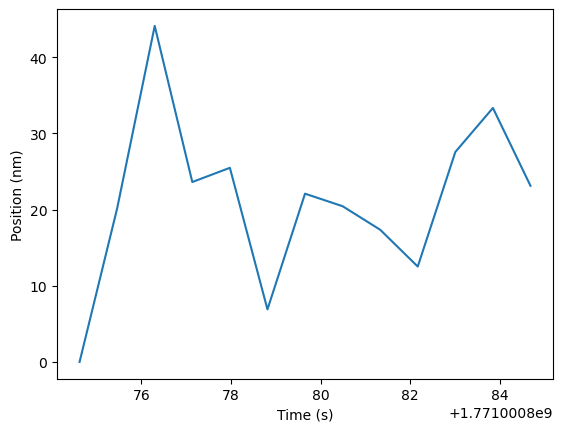

In [5]:
plt.plot(t_s,(pos0_pm-pos0_pm[0])*1e-3)
plt.xlabel('Time (s)')
plt.ylabel('Position (nm)')

## Moving the stage

### using the python package

In [6]:
#!pip install newportxps

In [7]:
from newportxps import NewportXPS

STAGE_NAME = 'Group1.Pos'
IP_ADDRESS = '192.168.10.20'
USERNAME = 'Administrator'
PASSWORD = 'Administrator'

# Connect to the controller (replace with your controller's IP or hostname)
xps = NewportXPS(IP_ADDRESS, username=USERNAME, password=PASSWORD)
# Get a status report
status = xps.status_report()
#print(status)

In [8]:
xps.read_stage_position(STAGE_NAME)


9.999995

In [9]:
#xps.get_group_status(STAGE_NAME)

In [10]:
xps.move_stage(STAGE_NAME, 10)

''

In [11]:
xps.move_stage(STAGE_NAME, 10)

''

### create an ophyd wrapper

In [ ]:
from ophyd import Device, Component as Cpt, EpicsMotor
from ophyd import Signal, DeviceStatus

class NewportXPSStage(Device):
    """Ophyd wrapper for Newport XPS stage"""
    
    # Create a soft positioner that wraps the XPS stage
    position = Cpt(Signal, value=0, kind='hinted')
    setpoint = Cpt(Signal, value=0, kind='normal')
    
    def __init__(self, xps_controller, stage_name, *args, **kwargs):
        self.xps = xps_controller
        self.stage_name = stage_name
        super().__init__(*args, **kwargs)
        # Initialize position from hardware
        self.position.put(self.xps.read_stage_position(self.stage_name))

    def trigger(self):
        """
        Trigger the detector and return a status object.
        """
        # 1. Create a status object associated with this device
        status = DeviceStatus(self)

        # # 2. Define a callback to clear the status when acquisition finishes
        # def callback(value, old_value, **kwargs):
        #     if old_value == 1 and value == 0:
        #         # Acquisition changed from 'Running' to 'Idle'
        #         status.set_finished()
        #         # Remove this internal subscription to clean up
        #         self.acquire.clear_sub(callback)

        # # 3. Subscribe the callback to the 'acquire' signal
        # self.acquire.subscribe(callback, run=False)

        # # 4. Start the hardware acquisition
        # self.acquire.put(1)
        status.set_finished()  # Placeholder: mark as finished immediately for this example

        # 5. Return the status object immediately; Bluesky will wait on it
        return status
    
    def set(self, new_position):
        """Move stage to position"""
        self.xps.move_stage(self.stage_name, new_position)
        self.position.put(new_position)
        self.setpoint.put(new_position)
        return self.position
    
    
    def read(self):
        """Read current position"""
        pos = self.xps.read_stage_position(self.stage_name)
        self.position.put(pos)
        return self.position.read()
    
    def get(self):
        """Get current position value"""
        return self.xps.read_stage_position(self.stage_name)
    
    def describe(self):
        return {
            self.name: {
                'source': 'Newport XPS Stage',
                'dtype': 'number',
                'shape': [],
            }
        }

# Create the ophyd stage object
stage = NewportXPSStage(xps, STAGE_NAME, name='newport_stage')

In [13]:
#just works
stage.set(10)  # Move to position 10

Signal(name='newport_stage_position1', parent='newport_stage', value=10, timestamp=1771001162.0507166)

In [14]:
stage.trigger()  # Trigger acquisition and get status object

DeviceStatus(device=newport_stage, done=True, success=True)

In [15]:
from bluesky import RunEngine

import bluesky.plans as bp
import bluesky.plan_stubs as bps

# Create a Run Engine
RE = RunEngine()

In [ ]:
interferometer = ophyd.EpicsSignal('CATERETE:PICOSCALE:POS_0')

RE(bp.scan([interferometer], stage, 0, 10, 5))

### using ophyd async